In [1]:
include("model.jl")
include("Parser.jl")
include("greedy.jl")
include("utils.jl")
using JuMP
using HiGHS

## Data processing

In [2]:
n, m, x_VC, y_VC, x_loc, y_loc, Q, C, q, f, p, tc, B, R, localities_with_high_priorities, M = parse_instance("./Instances/coord50-5-2_processed.dat")

(50, 5, [42.0, 47.0, 47.0, 7.0, 19.0], [4.0, 20.0, 49.0, 18.0, 18.0], [14.0, 20.0, 26.0, 17.0, 13.0, 12.0, 4.0, 21.0, 1.0, 2.0  …  37.0, 35.0, 42.0, 25.0, 39.0, 48.0, 41.0, 35.0, 41.0, 37.0], [14.0, 18.0, 1.0, 4.0, 3.0, 4.0, 10.0, 21.0, 19.0, 22.0  …  26.0, 48.0, 35.0, 40.0, 41.0, 41.0, 26.0, 27.0, 31.0, 31.0], 70, [350, 350, 350, 350, 350], [14, 19, 18, 17, 13, 17, 16, 16, 12, 18  …  13, 18, 14, 18, 16, 12, 12, 14, 14, 16], [12318, 11308, 8938, 14703, 9073], 1000, 0, 18444.994424751003, [8.509262392499917, 12.273554630314973, 17.435507895829222, 13.559429077507767, 11.15512985522207], [42, 41, 37, 6, 25], 5)

In [3]:
println("Budget: ", B)
println("Q = ", Q)
println("C = ", C)
println("M = ", M)

Budget: 18444.994424751003
Q = 70
C = [350, 350, 350, 350, 350]
M = 5


In [4]:
# Create the distance matrix
distance_matrix = zeros(Float64, m, n)

for i in 1:m 
    for j in 1:n
        distance_matrix[i, j] = sqrt((x_VC[i] - x_loc[j])^2 + (y_VC[i] - y_loc[j])^2)
    end
end


# Create reachability matrix a
A = zeros(Int, m, n)


for i in 1:m
    for j in 1:n
        if distance_matrix[i, j] <= R[i]
            A[i, j] = 1
        end
    end
end

In [5]:
D = zeros(Float64, n+m, n+m)
#The n first rows/cols of D relate to the localities, the m last to the VC
#In other words, calling D[i,j] for i in I, j in J corresponds to call D[i+n,j]
for i in 1:m+n
    for j in 1:m+n
        if i <= n && j <= n
            # Both indices in `loc`
            D[i, j] = sqrt((x_loc[i] - x_loc[j])^2 + (y_loc[i] - y_loc[j])^2)
        elseif i > n && j > n
            # Both indices in `VC`
            D[i, j] = sqrt((x_VC[i - n] - x_VC[j - n])^2 + (y_VC[i - n] - y_VC[j - n])^2)
        elseif i > n && j <= n
            # i in `VC`, j in `loc`
            D[i, j] = sqrt((x_VC[i - n] - x_loc[j])^2 + (y_VC[i - n] - y_loc[j])^2)
        else
            # i in `loc`, j in `VC`
            D[i, j] = sqrt((x_loc[i] - x_VC[j - n])^2 + (y_loc[i] - y_VC[j - n])^2)
        end
    end
end

## Greedy Algorithm

In [6]:
VC, MMTs, Budget, Q_MMTs, Q_tot = greedy_OptVax(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)


(5, [[(55, 55), (55, 6), (6, 25), (25, 37), (37, 42), (42, 55)], [(55, 55), (55, 41), (41, 48), (48, 50), (50, 39), (39, 35), (35, 55)], [(55, 55), (55, 31), (31, 32), (32, 28), (28, 38), (38, 55)], [(55, 55), (55, 49), (49, 43), (43, 29), (29, 36), (36, 55)], [(55, 55), (55, 44), (44, 40), (40, 34), (34, 26), (26, 55)]], 14171.941979206895, [68, 70, 70, 65, 64], 337)

In [7]:
new_MMTs = local_search_2Opt(MMTs, D)

5-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(55, 55), (55, 6), (6, 25), (25, 37), (37, 42), (42, 55)]
 [(55, 55), (55, 48), (48, 50), (50, 39), (39, 35), (35, 41), (41, 55)]
 [(55, 55), (55, 28), (28, 32), (32, 31), (31, 38), (38, 55)]
 [(55, 55), (55, 49), (49, 43), (43, 29), (29, 36), (36, 55)]
 [(55, 55), (55, 44), (44, 40), (40, 34), (34, 26), (26, 55)]

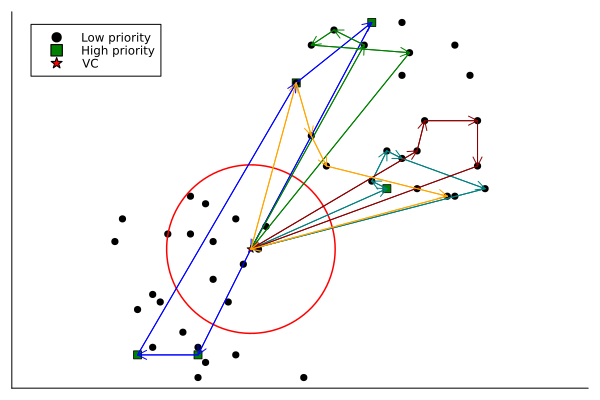

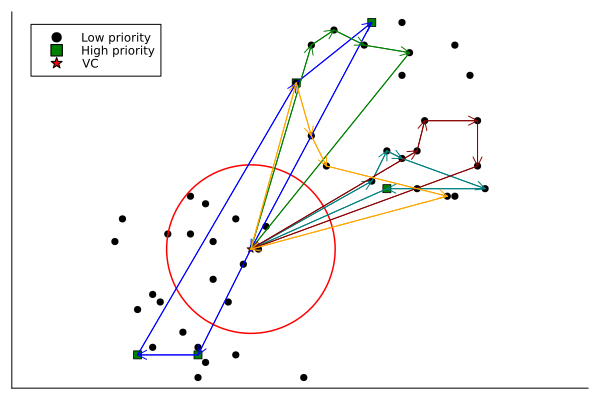

In [8]:
plot_solution_greedy(MMTs, x_VC, y_VC, x_loc, y_loc, R, n, m, M, localities_with_high_priorities)
plot_solution_greedy(new_MMTs, x_VC, y_VC, x_loc, y_loc, R, n, m, M, localities_with_high_priorities)

## Models Creation

### OptVax1

In [9]:
model_OptVax1 = solve_OptVax1(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
greedy_init(model_OptVax1, new_MMTs, VC, M, n, m, q)
optimize!(model_OptVax1)    

obj_val = objective_value(model_OptVax1)
println("Objective Value: ", obj_val)

InterruptException: Error trying to display an error.

### OptVax2

In [10]:
# model_OptVax2 = solve_OptVax2(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
# greedy_init(model_OptVax2, MMTs, VC, M, n, m, q)
# optimize!(model_OptVax2)


# obj_val = objective_value(model_OptVax2)
# println("Objective Value: ", obj_val)

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+04]
  Cost   [1e+01, 3e+02]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+04]
Assessing feasibility of MIP using primal feasibility and integrality tolerance of       1e-06
Solution has               num          max          sum
Col     infeasibilities      0            0            0
Integer infeasibilities      0            0            0
Row     infeasibilities      0            0            0
Row     residuals            0            0            0
Presolving model
27539 rows, 14955 cols, 128833 nonzeros  0s
27009 rows, 14425 cols, 124580 nonzeros  0s

MIP start solution is feasible, objective value is 497
Objective function is integral with scale 1

Solving MIP model with:
   27009 rows
   14425 cols (14375 binary, 50 integer, 0 implied int., 0 continuous)
   124580 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds           

### OptVax2LP

In [11]:
# model_OptVax2LP = solve_OptVax2LP(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
# greedy_init(model_OptVax2LP, MMTs, VC, M, n, m, q)
# optimize!(model_OptVax2LP)


# obj_val = objective_value(model_OptVax2LP)
# println("Objective Value: ", obj_val)

In [12]:
plot_solution(model_OptVax1, x_VC, y_VC, x_loc, y_loc, R,n,m,M, localities_with_high_priorities)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP /Users/theohanon/.julia/packages/JuMP/glJ0u/src/optimizer_interface.jl:761


OptimizeNotCalled: OptimizeNotCalled()